In [51]:
from plotly_calplot import calplot

from common.explore import display_sql

In [52]:
display_sql(f'''
WITH f_created_at AS (
    SELECT DISTINCT online_at
      FROM "main"."main"."fact_online_job" f
), max_normalized AS (
    SELECT MAX(online_at)
      FROM "main"."main"."normalized_online_job"
), n_created_at AS (
    SELECT DISTINCT online_at
      FROM "main"."main"."normalized_online_job"
)
SELECT * FROM n_created_at
WHERE online_at != (SELECT * FROM max_normalized)
ORDER BY 1
''')

,online_at
0,2021-10-09
1,2021-10-10
2,2021-10-11
3,2021-10-12
4,2021-10-13
...,...
370,2022-10-14
371,2022-10-15
372,2022-10-16
373,2022-10-17


In [53]:
display_sql(f'''
CREATE OR REPLACE VIEW test_changelog AS
WITH f_created_at AS (
    SELECT DISTINCT online_at
      FROM "main"."main"."fact_online_job" f
), max_normalized AS (
    SELECT MAX(online_at)
      FROM "main"."main"."normalized_online_job"
), n_created_at AS (
    SELECT DISTINCT online_at
      FROM "main"."main"."normalized_online_job"
), n_created_at_without_max AS (
    SELECT *
      FROM n_created_at
     WHERE online_at != (SELECT * FROM max_normalized)
     ORDER BY 1
), to_materialize AS (

    SELECT DISTINCT f.online_at
      FROM f_created_at f


     LEFT OUTER JOIN n_created_at_without_max n
       ON (f.online_at = n.online_at)
    WHERE n.online_at IS NULL


    ORDER BY 1

), normalized AS (
    SELECT f.online_at,
           f.job_id,
           j.company_name,
           l.location_name,
           t.technology_name
      FROM to_materialize tm
      JOIN "main"."main"."fact_online_job" f
        ON (tm.online_at = f.online_at)
      JOIN "main"."main"."dim_job" j
        ON (f.job_key = j.job_key)
      JOIN "main"."main"."dim_job_location" l
        ON (f.job_key = l.job_key)
      JOIN "main"."main"."dim_job_technology" t
        ON (f.job_key = t.job_key)
     ORDER BY 1
), normalized_with_previous AS (
    SELECT job_id,
           location_name,
           company_name,
           technology_name,
           online_at,
           online_at - INTERVAL 1 DAY AS previous_day
      FROM normalized
), min_online_at AS (
    SELECT MIN(online_at)
      FROM normalized_with_previous
), max_online_at AS (
    SELECT MAX(online_at)
      FROM normalized_with_previous
), joined_normalized_with_previous AS (
    SELECT DISTINCT
           c.job_id,
           c.online_at,
           c.location_name,
           c.company_name,
           c.technology_name,
           p.location_name AS previous_location_name,
           p.company_name AS previous_company_name,
           p.technology_name AS previous_technology_name,
           p.online_at AS previous_online_at,
           p.job_id AS previous_job_id
      FROM normalized_with_previous c
      FULL OUTER JOIN normalized_with_previous p
        ON (c.job_id = p.job_id AND
            c.location_name = p.location_name AND
            c.company_name = p.company_name AND
            c.technology_name = p.technology_name AND
            c.previous_day = p.online_at)
)
SELECT COALESCE(job_id, previous_job_id) AS job_id,
       COALESCE(location_name, previous_location_name) AS location_name,
       COALESCE(company_name, previous_company_name) AS company_name,
       COALESCE(technology_name, previous_technology_name) AS technology_name,
       COALESCE(online_at, previous_online_at) AS online_at,
       previous_job_id IS NULL AS added,
       job_id IS NULL AS deleted
  FROM joined_normalized_with_previous
 WHERE NOT COALESCE(online_at, previous_online_at) IN (SELECT * FROM max_online_at)
   AND NOT COALESCE(online_at, previous_online_at) IN (SELECT * FROM min_online_at)
''', read_only=False)

,Count


In [54]:
df = display_sql(f'''
SELECT online_at,
       added,
       deleted,
       COUNT(DISTINCT job_id)
  FROM test_changelog
-- WHERE added OR deleted
 GROUP BY 1, 2, 3
 ORDER BY 1, 2, 3
''')
df

,online_at,added,deleted,count(DISTINCT job_id)
0,2022-10-20,False,False,147731
1,2022-10-20,False,True,3609
2,2022-10-20,True,False,5164


In [55]:
df = display_sql(f'''
SELECT online_at,
       COUNT(DISTINCT job_id) AS added
  FROM test_changelog
 WHERE added
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,added
0,2022-10-20,5164


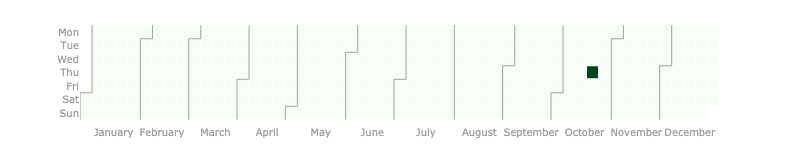

In [56]:
fig = calplot(
    df,
    x='online_at',
    y='added',
    colorscale='Greens'
)
fig.show('png')

In [57]:
df = display_sql(f'''
SELECT online_at,
       COUNT(DISTINCT job_id) AS deleted
  FROM test_changelog
 WHERE deleted
 GROUP BY 1
 ORDER BY 1
''')
df

,online_at,deleted
0,2022-10-20,3609


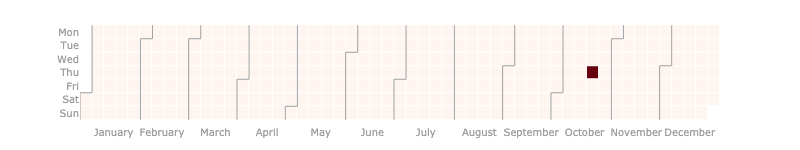

In [58]:
fig = calplot(
    df,
    x='online_at',
    y='deleted',
    colorscale='Reds'
)
fig.show('png')

In [59]:
display_sql(f'''
DROP VIEW test_changelog
''', read_only=False)

,Success
